In [1]:
import scanpy as sc
import anndata as ad
import scanpy.external as sce

import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

import gseapy as gp

import matplotlib.pyplot as plt
import seaborn as sns

from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz
import sccoda.datasets as scd
import pickle

import scvi
import torch
import scipy.sparse as sp

from rich import print
import warnings
warnings.filterwarnings("ignore")
import os

outdir = "../../../write/03_batch_expression/PICA0001-PICA0007"
os.makedirs(outdir, exist_ok=True)
sc.settings.figdir = "../../../figures/PICA0001-PICA0007/03_abundance_change"

/Users/jessica/mambaforge/envs/scanpy/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load cd4 annotations
cd4 = sc.read_h5ad("../../../write/02_cd4_batch_annotation/PICA0001-PICA0007/PICA0001-PICA0007_cd4_scVI_annot_tfh.h5ad")

cd4.obs['cell_type'].unique()
cd4.obs['cell_type'].value_counts()

cell_type
Naive/Central memory CD4 T cell    8105
Tfh / cTfh                         1268
Regulatory T cell                   267
CCR6+ memory CD4 T cell             221
Cytotoxic CD4 T cell                 43
Name: count, dtype: int64

In [3]:
cd4.obs["pica_id"].unique()
cd4.obs['pica_id'].value_counts()

pica_id
PICA0001    2399
PICA0007    1868
PICA0006    1571
PICA0004    1204
PICA0003    1172
PICA0002    1009
PICA0005     681
Name: count, dtype: int64

In [4]:
# load nk and t annotations
annot = sc.read_h5ad("../../../data/batch_integration_1-3_nk_t_subset.h5ad")

annot.obs['cell_type'].unique()
annot.obs['cell_type'].value_counts()

cell_type
Naive/Central memory CD4 T cell      146572
Cytotoxic NK cell                     67398
Naive/Central memory CD8 T cell       53031
Gamma-delta T cell                    34979
CCR4+ CCR6+ memory CD4 T cell         33058
TIGIT+ TOX+ memory CD4 T cell         16359
CCR6+ memory CD4 T cell               15790
MAIT                                  14464
Treg                                  13752
DN gdT cell                           12665
TOX+ CD8 T cell                       10989
CD27- CCR7- suppressed CD8 T cell      9906
CD8+ gdT cell                          8854
NKT                                    7889
NK-like gamma-delta T cell             6846
Cytotoxic natural killer cell          5964
CD27+ CCR7+ suppressed CD8 T cell      5363
CD27+ CCR7- suppressed CD8 T cell      4888
GZMK+ CD8 T cell                       3594
Cytokine-producing NK cell             3291
CCR4+ memory CD4 T cell                2203
Cytotoxic CD4 T cell                   1207
Innate-like CD4 T cell

In [5]:
annot.obs["pica_id"].unique()
annot.obs['pica_id'].value_counts()

pica_id
PICA0024    14203
PICA0008    14119
PICA0015    11988
PICA0035    11882
PICA0029    11632
PICA0011    11549
PICA0022    11545
PICA0009    11386
PICA0039    11353
PICA0051    11188
PICA0036    10892
PICA0044    10815
PICA0050    10800
PICA0023    10715
PICA0043    10693
PICA0028    10628
PICA0013    10582
PICA0016    10551
PICA0040    10501
PICA0034    10498
PICA0033    10317
PICA0014    10199
PICA0048    10004
PICA0020     9966
PICA0063     9930
PICA0010     9856
PICA0055     9679
PICA0012     9511
PICA0037     9483
PICA0065     9434
PICA0056     9322
PICA0059     9211
PICA0032     9206
PICA0052     9064
PICA0018     8958
PICA0046     8951
PICA0057     8909
PICA0069     8838
PICA0047     8768
PICA0025     8756
PICA0019     8712
PICA0017     8189
PICA0031     7821
PICA0030     7080
PICA0061     6923
PICA0049     6237
PICA0005     4250
PICA0001     3734
PICA0007     3567
PICA0006     3102
PICA0004     2537
PICA0002     2442
PICA0003     2233
Name: count, dtype: int64

### Filter to show PICA0001-PICA0007 in both annotations

In [6]:
# keep common ids (PICA0001-PICA0007)
annot_res = annot.copy()
cd4_copy   = cd4.copy()

keep = [f"PICA{i:04d}" for i in range(1, 8)]
annot_res = annot_res[annot_res.obs["pica_id"].isin(keep)].copy()

In [7]:
print(annot_res.obs["pica_id"].unique())
print(annot_res.obs['pica_id'].value_counts())

['PICA0007', 'PICA0002', 'PICA0001', 'PICA0003', 'PICA0006', 'PICA0004', 'PICA0005']
Categories (7, object): ['PICA0001', 'PICA0002', 'PICA0003', 'PICA0004', 'PICA0005', 'PICA0006', 'PICA0007']

pica_id
PICA0005    4250
PICA0001    3734
PICA0007    3567
PICA0006    3102
PICA0004    2537
PICA0002    2442
PICA0003    2233
Name: count, dtype: int64

In [8]:
annot_res.obs['cell_type'].unique()
annot_res.obs['cell_type'].value_counts()

cell_type
Naive/Central memory CD4 T cell    9527
Cytotoxic natural killer cell      5964
Naive/Central memory CD8 T cell    3233
Gamma-delta T cell                 1109
Suppressed CD8 T cell               848
Efector memory CD8 T cell           328
GZMK+ memory CD8 T cell             269
Regulatory T cell                   267
CCR6+ memory CD4 T cell             222
NKT cell                             55
Cytotoxic CD4 T cell                 43
Name: count, dtype: int64

### Merge both annotation files

In [9]:
annot_res.obs_names = annot_res.obs_names.astype(str)
cd4_copy.obs_names   = cd4_copy.obs_names.astype(str)

annot_res.obs["dataset_source"] = "annot_T_NK"
cd4_copy.obs["dataset_source"]   = "annot_CD4_TFH"

In [10]:
# concatenate annotations for PICA0001-PICA0007
combined = sc.concat(
    [annot_res, cd4_copy],
    join="outer",
    label="origin",                             
    keys=["annot_T_NK", "annot_CD4_TFH"],  
    index_unique=None
)

print("Combined AnnData shape:", combined.shape)
print("Unique donors in combined:", combined.obs["pica_id"].unique().tolist())

Combined AnnData shape:
(31769, 38606)

Unique donors in combined:
['PICA0007', 'PICA0002', 'PICA0001', 'PICA0003', 'PICA0006', 'PICA0004', 'PICA0005']

In [11]:
print(combined.obs["origin"].value_counts())
print(combined.obs["cell_type"].value_counts())

origin
annot_T_NK       21865
annot_CD4_TFH     9904
Name: count, dtype: int64

cell_type
Naive/Central memory CD4 T cell    17632
Cytotoxic natural killer cell       5964
Naive/Central memory CD8 T cell     3233
Tfh / cTfh                          1268
Gamma-delta T cell                  1109
Suppressed CD8 T cell                848
Regulatory T cell                    534
CCR6+ memory CD4 T cell              443
Efector memory CD8 T cell            328
GZMK+ memory CD8 T cell              269
Cytotoxic CD4 T cell                  86
NKT cell                              55
Name: count, dtype: int64

In [12]:
combined.write_h5ad("../../../write/03_batch_expression/PICA0001-PICA0007/PICA0001-PICA0007_combined_T_NK_CD4.h5ad", compression="gzip")


In [13]:
adata = sc.read_h5ad("../../../write/03_batch_expression/PICA0001-PICA0007/PICA0001-PICA0007_combined_T_NK_CD4.h5ad")

### Load metadata

In [14]:
adata

AnnData object with n_obs × n_vars = 31769 × 38606
    obs: 'status', 'assignment', 'pica_id', 'pool_id', 'sequencing_batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'status_manual', 'cell_type', 'status_manual_01_b_subset', 'broad_cell_type', 'cell_type_01_b_cell', 'cell_type_01_b_cell_corrected', 'cell_type_02_t_cell_broad', 'cell_type_03_t_cell_subtype', 'cell_type_04_myeloid_subset', 'dataset_source', '_scvi_batch', '_scvi_labels', 'leiden_res_0.5', 'leiden_res_1.0', 'leiden_res_1.5', 'leiden_res_2.0', 'cell_type_cd4_res_1', 'origin'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    layers: 'counts'

In [15]:
adata.obs['cell_type'].unique()
adata.obs['cell_type'].value_counts()

cell_type
Naive/Central memory CD4 T cell    17632
Cytotoxic natural killer cell       5964
Naive/Central memory CD8 T cell     3233
Tfh / cTfh                          1268
Gamma-delta T cell                  1109
Suppressed CD8 T cell                848
Regulatory T cell                    534
CCR6+ memory CD4 T cell              443
Efector memory CD8 T cell            328
GZMK+ memory CD8 T cell              269
Cytotoxic CD4 T cell                  86
NKT cell                              55
Name: count, dtype: int64

In [16]:
# load metadata
meta_raw = pd.read_csv("../../../data/PICA-PICAReportOverall_DATA_LABELS_2025-07-25_1224.csv", index_col=0)

In [17]:
print(meta_raw["IFC ID"])

Record ID
1      IFC-00001
2      IFC-00002
3      IFC-00003
4      IFC-00004
5      IFC-00005
         ...    
269    IFC-00262
270    IFC-00263
271     IFC-0264
272     IFC-0265
273    IFC-00266
Name: IFC ID, Length: 273, dtype: object

In [18]:
# convert IFC ID -> PICA format (PICA0001)
meta = meta_raw.copy()
meta["IFC ID"] = meta["IFC ID"].fillna("0").astype(str)
meta["IFC ID"] = meta["IFC ID"].astype(str)

meta["pica_id"] = (
    meta["IFC ID"]
    .str.extract(r"(\d+)")[0]
    .fillna("0")
    .astype(int)
    .apply(lambda x: f"PICA{x:04d}")
)
meta.set_index("pica_id", inplace=True)

print(meta["IFC ID"])

pica_id
PICA0001    IFC-00001
PICA0002    IFC-00002
PICA0003    IFC-00003
PICA0004    IFC-00004
PICA0005    IFC-00005
              ...    
PICA0262    IFC-00262
PICA0263    IFC-00263
PICA0264     IFC-0264
PICA0265     IFC-0265
PICA0266    IFC-00266
Name: IFC ID, Length: 273, dtype: object

In [19]:
# restrict meta to only those in adata
adata_picas = adata.obs["pica_id"].unique()
meta_sub = meta.loc[meta.index.isin(adata_picas)]
adata_sub = adata[adata.obs["pica_id"].isin(meta_sub.index)].copy()

print(f"Metadata before: {meta.shape[0]} rows")
print(f"Metadata after subsetting: {meta_sub.shape[0]} rows")
print(f"AnnData before: {adata.shape[0]} cells")
print(f"AnnData after subsetting: {adata_sub.shape[0]} cells")

Metadata before: 273 rows

Metadata after subsetting: 7 rows

AnnData before: 31769 cells

AnnData after subsetting: 31769 cells

In [20]:
# join metadata to adata
adata_with_meta = adata_sub.copy()

adata_with_meta.obs["pica_id"] = adata_with_meta.obs["pica_id"].astype("string")
adata_with_meta.obs = adata_with_meta.obs.join(meta_sub, on="pica_id", how="left", rsuffix="_meta")

In [21]:
print("Unique donors in metadata subset:", meta_sub.index.unique().tolist())
print("Unique donors in adata_with_meta:", adata_with_meta.obs['pica_id'].unique().tolist())


Unique donors in metadata subset:
['PICA0001', 'PICA0002', 'PICA0003', 'PICA0004', 'PICA0005', 'PICA0006', 'PICA0007']

Unique donors in adata_with_meta:
['PICA0007', 'PICA0002', 'PICA0001', 'PICA0003', 'PICA0006', 'PICA0004', 'PICA0005']

In [22]:
meta_summary = (
    adata_with_meta.obs[["pica_id", "Child's sex", "Age in years at the time of collection"]]
    .drop_duplicates()
    .sort_values("pica_id")
)
print(meta_summary)

pica_id Child's sex  \
20240530_WGS_20240530_sc_PICA0001-PICA0007_2024...  PICA0001        Male   
20240530_WGS_20240530_sc_PICA0001-PICA0007_2024...  PICA0002        Male   
20240530_WGS_20240530_sc_PICA0001-PICA0007_2024...  PICA0003        Male   
20240530_WGS_20240530_sc_PICA0001-PICA0007_2024...  PICA0004        Male   
20240530_WGS_20240530_sc_PICA0001-PICA0007_2024...  PICA0005        Male   
20240530_WGS_20240530_sc_PICA0001-PICA0007_2024...  PICA0006        Male   
20240530_WGS_20240530_sc_PICA0001-PICA0007_2024...  PICA0007        Male   

                                                    Age in years at the time of collection  
20240530_WGS_20240530_sc_PICA0001-PICA0007_2024...                                    2.09  
20240530_WGS_20240530_sc_PICA0001-PICA0007_2024...                                   15.09  
20240530_WGS_20240530_sc_PICA0001-PICA0007_2024...                                    0.83  
20240530_WGS_20240530_sc_PICA0001-PICA0007_2024...                                    3.46  
20240530_WGS_20240530_sc_PICA0001-PICA0007_2024...                                    9.30  
20240530_WGS_20240530_sc_PICA0001-PICA0007_2024...                                    0.14  
20240530_WGS_20240530_sc_PICA0001-PICA0007_2024...                                    3.17

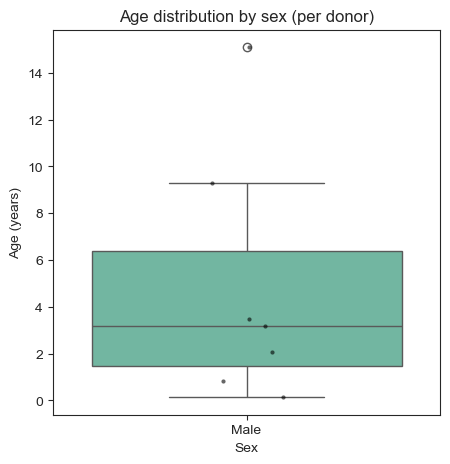

In [23]:
meta_df = adata_with_meta.obs[['pica_id', "Child's sex", "Age in years at the time of collection"]].drop_duplicates()

plt.figure(figsize=(5,5))
sns.boxplot(data=meta_df, x="Child's sex", y="Age in years at the time of collection", palette="Set2")
sns.stripplot(data=meta_df, x="Child's sex", y="Age in years at the time of collection", color="k", size=3, alpha=0.6)
plt.title("Age distribution by sex (per donor)")
plt.ylabel("Age (years)")
plt.xlabel("Sex")
plt.show()

In [24]:
adata_with_meta.obs = adata_with_meta.obs.applymap(
    lambda x: str(x) if not isinstance(x, (int, float, str)) else x
)

In [25]:
adata_with_meta.write_h5ad("../../../write/03_batch_expression/PICA0001-PICA0007/PICA0001-PICA0007_combined_annot_meta.h5ad", compression="gzip")

In [26]:
adata_age=sc.read_h5ad("../../../write/03_batch_expression/PICA0001-PICA0007/PICA0001-PICA0007_combined_annot_meta.h5ad")

### Clean up age

In [27]:
adata_age.obs.groupby("pica_id")["Age in years at the time of collection"].unique()

pica_id
PICA0001     [2.09]
PICA0002    [15.09]
PICA0003     [0.83]
PICA0004     [3.46]
PICA0005      [9.3]
PICA0006     [0.14]
PICA0007     [3.17]
Name: Age in years at the time of collection, dtype: object

In [28]:
adata_age.obs["Age in years int"] = (
    adata_age.obs["Age in years at the time of collection"]
    .astype(float)
    .apply(np.floor)  
    .astype(int)
)

In [29]:
adata_age.obs.groupby("pica_id")["Age in years int"].unique()

pica_id
PICA0001     [2]
PICA0002    [15]
PICA0003     [0]
PICA0004     [3]
PICA0005     [9]
PICA0006     [0]
PICA0007     [3]
Name: Age in years int, dtype: object

In [30]:
# Define bins and labels
bins = [0, 3, 6, 10, 14, 18]
labels = ["0–3", "4–6", "7–10", "11–14", "15–18"]

# Create new column for grouped ages
adata_age.obs["Age_group"] = pd.cut(
    adata_age.obs["Age in years int"],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=True
)

In [31]:
adata_age.obs["Age_group"].value_counts().sort_index()

Age_group
0–3      23387
4–6          0
7–10      4931
11–14        0
15–18     3451
Name: count, dtype: int64

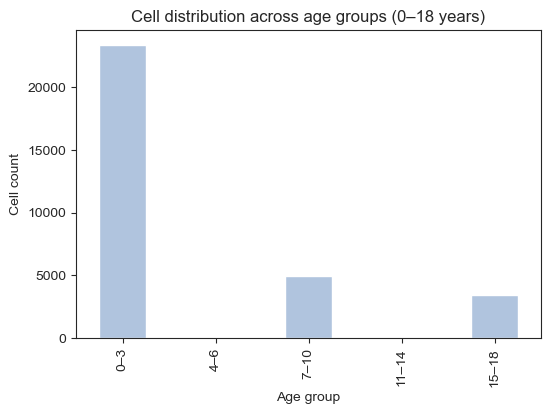

In [32]:
adata_age.obs["Age_group"].value_counts().sort_index().plot(
    kind="bar", figsize=(6,4), color="lightsteelblue"
)
plt.title("Cell distribution across age groups (0–18 years)")
plt.xlabel("Age group")
plt.ylabel("Cell count")
plt.show()

In [33]:
# create donor-level age group summary
age_meta_df = adata_age.obs[["pica_id", "Age_group"]].drop_duplicates()
age_meta_df["Age_group"].value_counts().sort_index()

Age_group
0–3      5
4–6      0
7–10     1
11–14    0
15–18    1
Name: count, dtype: int64

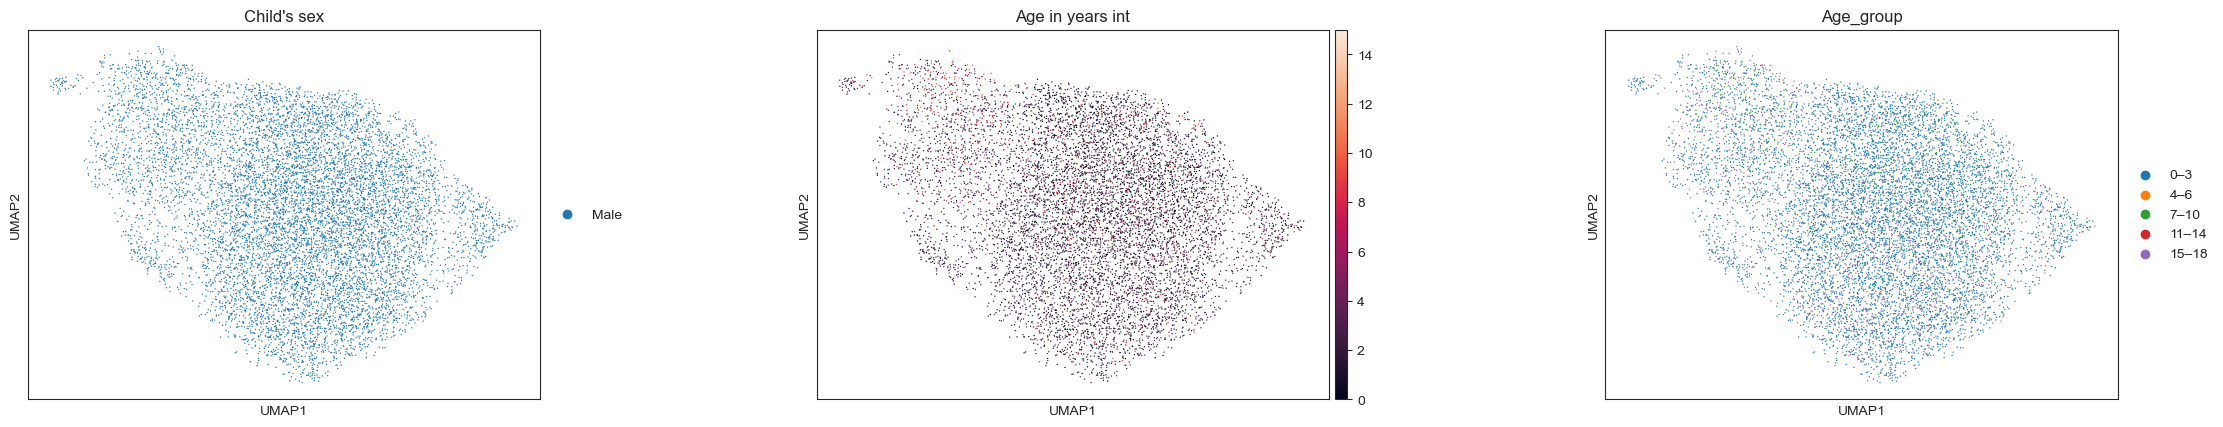

In [34]:
sc.pl.umap(adata_age, color=["Child's sex", "Age in years int", "Age_group"], wspace=0.4)

In [35]:
adata_age.write_h5ad("../../../write/03_batch_expression/PICA0001-PICA0007/PICA0001-PICA0007_combined_annot_with_age.h5ad", compression="gzip")

### Convert to sce object

In [37]:
adata_age_raw = sc.read_h5ad("../../../write/03_batch_expression/PICA0001-PICA0007/PICA0001-PICA0007_combined_annot_with_age.h5ad")

In [39]:
print(adata_age_raw)


AnnData object with n_obs × n_vars = 31769 × 38606
    obs: 'status', 'assignment', 'pica_id', 'pool_id', 'sequencing_batch', 'n_genes_by_counts', 
'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 
'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 
'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 
'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'status_manual', 'cell_type', 
'status_manual_01_b_subset', 'broad_cell_type', 'cell_type_01_b_cell', 'cell_type_01_b_cell_corrected', 
'cell_type_02_t_cell_broad', 'cell_type_03_t_cell_subtype', 'cell_type_04_myeloid_subset', 'dataset_source', 
'_scvi_batch', '_scvi_labels', 'leiden_res_0.5', 'leiden_res_1.0', 'leiden_res_1.5', 'leiden_res_2.0', 
'cell_type_cd4_res_1', 'origin', 'Event Name', 'Was baseline blood sample collected?', 'IFC ID', "Child's sex", 
'Age in years at the time of collection', 'Age in months at the time of collection', '1) Does your child have any 
significant health issue or condition?', 'Date and time of blood collection', '4) Does your child have any 
allergies diagnosed by a medical practitioner?', '5) Has your child shown any allergic symptoms within the last 2 
months?', '7) Is your child on any medication? (including immune-modulating medications like steroids in the last 
two weeks)?', '6) Does your child or your family have any history of immune disease? (such as immunodeficiencies 
and autoimmune disorders like lupus, type 1 diabetes, vasculitis, etc.) (choice=No)', '6) Does your child or your 
family have any history of immune disease? (such as immunodeficiencies and autoimmune disorders like lupus, type 1 
diabetes, vasculitis, etc.) (choice=Child)', '6) Does your child or your family have any history of immune disease?
(such as immunodeficiencies and autoimmune disorders like lupus, type 1 diabetes, vasculitis, etc.) (choice=Family 
member(s))', 'My family member has a history of (specify family member)', 'My child has a history of:  (Specify 
diagnosis date)', '8) Has your child ever been breastfed?', "9) What is your child's ethnicity? (choice=White 
Australian)", "9) What is your child's ethnicity? (choice=Australian Aboriginal)", "9) What is your child's 
ethnicity? (choice=Australian South Sea Islander)", "9) What is your child's ethnicity? (choice=Torres Strait 
Islander)", "9) What is your child's ethnicity? (choice=Māori)", "9) What is your child's ethnicity? (choice=New 
Zealander)", "9) What is your child's ethnicity? (choice=Pacific Islander)", "9) What is your child's ethnicity? 
(choice=North-West European)", "9) What is your child's ethnicity? (choice=Southern and Eastern European)", "9) 
What is your child's ethnicity? (choice=North African and Middle Eastern)", "9) What is your child's ethnicity? 
(choice=South-East Asian)", "9) What is your child's ethnicity? (choice=North-East Asian)", "9) What is your 
child's ethnicity? (choice=Southern and Central Asian)", "9) What is your child's ethnicity? (choice=Latin American
and Caribbean)", "9) What is your child's ethnicity? (choice=Sub-Saharan African)", "9) What is your child's 
ethnicity? (choice=Decline to answer)", "9) What is your child's ethnicity? (choice=Other, please specify:)", 
'Specify ethnicity', 'Age in years int', 'Age_group'
    uns: 'Age_group_colors', "Child's sex_colors"
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    layers: 'counts'

In [42]:
import os
os.environ["R_HOME"] = "/opt/homebrew/Cellar/r/4.5.2/lib/R" 

import anndata2ri
import rpy2.robjects as robjects
from rpy2.robjects.conversion import localconverter


with localconverter(anndata2ri.converter):
    sce = anndata2ri.py2rpy(adata)

# Save the sce object in .rds file
robjects.globalenv["sce"] = sce
robjects.r("saveRDS(sce, file='{}')".format("../../../write/03_batch_expression/PICA0001-PICA0007/PICA0001-PICA0007_combined_annot_with_age.sce.rds"))

Error importing in API mode: ImportError("dlopen(/Users/jessica/mambaforge/envs/scanpy/lib/python3.10/site-packages/_rinterface_cffi_api.abi3.so, 0x0002): Library not loaded: /Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib\n  Referenced from: <2EEBEE81-EBFD-3117-97B1-20AFEEB66792> /Users/jessica/mambaforge/envs/scanpy/lib/python3.10/site-packages/_rinterface_cffi_api.abi3.so\n  Reason: tried: '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file)")
Trying to import in ABI mode.
